#This notebook is dedicated to building a Small Language Model (SLM) entirely from scratch using Python and PyTorch.

#Step 1: Downloading Packages

In [ ]:
!pip install datasets==3.6.0 -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 24.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6

#Step 2: Loading Data

In [ ]:
from datasets import load_dataset

ds = load_dataset("fhswf/TinyStoriesV2_cleaned")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

part1.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part10.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part11.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part12.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part13.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part14.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part15.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part16.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part17.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part18.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part19.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part2.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part20.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part21.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part22.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part23.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part24.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part25.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part26.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part27.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part3.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part4.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part5.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part6.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part7.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part8.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part9.txt:   0%|          | 0.00/80.0M [00:00<?, ?B/s]

part1.txt:   0%|          | 0.00/56.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2646014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/68767 [00:00<?, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2646014
    })
    test: Dataset({
        features: ['text'],
        num_rows: 68767
    })
})

In [ ]:
ds.shape

{'train': (2646014, 1), 'test': (68767, 1)}

#Step 3: Tokenize Data

In [ ]:
!pip install tiktoken -q

In [ ]:
import tiktoken
import os
import numpy as np
from tqdm.auto import tqdm

enc = tiktoken.get_encoding("gpt2")

def process(example):
  ids = enc.encode_ordinary(example["text"])
  out = {"ids":ids, "len":len(ids)}
  return out

if not os.path.exists("train.bin"):
  tokenized = ds.map(
      process,
      remove_columns=['text'],
      desc="tokenizing the splits",
      num_proc=8
  )

  for split, dset in tokenized.items():
    arr_len = np.sum(dset['len'], dtype=np.int64)
    filename = f"{split}.bin"
    dtype = np.uint16
    arr = np.memmap(filename, dtype=dtype, mode="w+", shape=(arr_len,))
    total_batches = 1024

    idx = 0
    for batch_idx in tqdm(range(total_batches), desc=f"writing {filename}"):
      batch = dset.shard(num_shards=total_batches, index=batch_idx, contiguous=True).with_format("numpy")

      arr_batch = np.concatenate(batch['ids'])

      arr[idx:idx+len(arr_batch)] = arr_batch
      idx += len(arr_batch)

    arr.flush()

tokenizing the splits (num_proc=8):   0%|          | 0/2646014 [00:00<?, ? examples/s]

tokenizing the splits (num_proc=8):   0%|          | 0/68767 [00:00<?, ? examples/s]

writing train.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

writing test.bin:   0%|          | 0/1024 [00:00<?, ?it/s]

#Step 3: Creating Input-Output Batches for Dataset

In [ ]:
def get_batch(split):
  if split == "train":
    data = np.memmap('train.bin', dtype=np.uint16, mode='r')
  else:
    data = np.memmap('test.bin', dtype=np.uint16, mode="r")

  ix = torch.randint(len(data) - block_size, (batch_size,))
  x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
  y = torch.stack([torch.from_numpy((data[i+1:i+1+block_size]).astype(np.int64)) for i in ix])

  if device_type == "cuda":
    x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
  else:
    x, y = x.to(device), y.to(device)
  return x, y

#Step 4: Building Model

####Defining SLM Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from dataclasses import dataclass
import numpy as np
from tqdm.auto import tqdm
from contextlib import nullcontext
import os

class LayerNorm(nn.Module):
  def __init__(self, ndim, bias):
    super().__init__()

    self.weight = nn.Parameter(torch.ones(ndim))
    self.bias = nn.Parameter(torch.zeros(ndim))

  def forward(self, x):
    return F.layer_norm(x, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):
  def __init__(self, config):
    super().__init__()
    assert config.n_embd % config.n_head == 0

    self.c_attn = nn.Linear(config.n_embd, 3*config.n_embd, bias=config.bias)
    self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
    self.attn_dropout = nn.Dropout(config.dropout)
    self.resid_dropout = nn.Dropout(config.dropout)
    self.n_head = config.n_head
    self.n_embd = config.n_embd
    self.flash = hasattr(F, 'scaled_dot_product_attention')
    if not self.flash:
      self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))

  def forward(self, x):
    B, T, C = x.size()
    q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
    k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
    q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
    v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

    if self.flash:
      y = F.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.attn_dropout.p if self.training else 0.0, is_causal=True)
    else:
      att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
      att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
      att = F.softmax(att, dim=-1)
      att = self.attn_dropout(att)
      y = att @ v

    y = y.transpose(1, 2).contiguous().view(B, T, C)
    y = self.resid_dropout(self.c_proj(y))
    return y

class MLP(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.c_fc = nn.Linear(config.n_embd, 4*config.n_embd, bias=config.bias)
    self.gelu = nn.GELU()
    self.c_proj = nn.Linear(4*config.n_embd, config.n_embd, bias=config.bias)
    self.dropout = nn.Dropout(config.dropout)

  def forward(self, x):
    return self.dropout(self.c_proj(self.gelu(self.c_fc(x))))

class Block(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.ln1 = LayerNorm(config.n_embd, config.bias)
    self.attn = CausalSelfAttention(config)
    self.ln2 = LayerNorm(config.n_embd, config.bias)
    self.mlp = MLP(config)

  def forward(self, x):
    x = x + self.attn(self.ln1(x))
    x = x + self.mlp(self.ln2(x))
    return x

@dataclass
class GPTConfig:
  block_size: int
  vocab_size: int
  n_layer: int
  n_head: int
  n_embd: int
  dropout: float = 0.0
  bias: bool = True

class GPT(nn.Module):
  def __init__(self, config):
    super().__init__()

    self.config = config
    self.transformer = nn.ModuleDict(
        dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, config.bias)
        )
    )
    self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
    self.transformer.wte.weight = self.lm_head.weight

    self.apply(self._init_weights)
    for pn, p in self.named_parameters():
      if pn.endswith("c_proj.weight"):
        nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2*config.n_layer))

  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
      nn.init.normal_(module.weight, mean=0.0, std=0.02)
      if module.bias is not None:
        nn.init.zeros_(module.bias)
    elif isinstance(module, nn.Embedding):
      nn.init.normal_(module.weight, mean=0.0, std=0.02)

  def forward(self, idx, targets=None):
    device = idx.device
    b, t = idx.size()
    assert t <= self.config.block_size
    pos = torch.arange(0, t, dtype=torch.long, device=device)

    tok_emb = self.transformer.wte(idx)
    pos_emb = self.transformer.wpe(pos)
    x = self.transformer.drop(tok_emb + pos_emb)
    for block in self.transformer.h:
      x = block(x)
    x = self.transformer.ln_f(x)

    if targets is not None:
      logits = self.lm_head(x)
      loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
      return logits, loss
    else:
      logits = self.lm_head(x[:, [-1], :])
      return logits, None

  @torch.no_grad()
  def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):

    for _ in range(max_new_tokens):
      idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
      logits, _ = self(idx_cond)
      if top_k is not None:
        v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
        logits[logits < v[:, [-1]]] = -float("Inf")
      probs = F.softmax(logits, dim=-1)
      # print(f"probs:{probs.squeeze(dim=1)} | {probs.squeeze(dim=1)}")
      # idx_next = torch.multinomial(probs, num_samples=1)
      idx_next = torch.multinomial(probs.squeeze(dim=1), num_samples=1)
      idx = torch.cat((idx, idx_next), dim=1)
    return idx

####Creating Instance of Model

In [ ]:
config = GPTConfig(
    block_size=128,
    vocab_size=50257,
    n_layer=6,
    n_head=6,
    n_embd=384,
    dropout=0.1,
    bias=True

)

model = GPT(config)

####Defining Loss Function

In [ ]:
def estimate_loss(model):
  out = {}
  model.eval()
  with torch.inference_mode():
    for split in ['train', 'test']:
      losses = torch.zeros(eval_iters)
      for k in range(eval_iters):
        X, Y = get_batch(split)
        with ctx:
          logits, loss = model(X, Y)
        losses[k] = loss.item()
      out[split] = losses.mean()
  model.train()
  return out

####Defining SLM Training Configuration

In [ ]:
import torch
from contextlib import nullcontext

learning_rate = 1e-4
max_iters = 40000
warmup_steps = 1000
min_lr = 5e-4
eval_iters = 500
batch_size = 32
block_size = 128

gradient_accumulation_steps = 32

device = "cuda" if torch.cuda.is_available() else "cpu"
device_type = 'cuda' if "cuda" in device else "cpu"

dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else "float16"
ptdtype = {"float32": torch.float32, "bfloat16":torch.bfloat16, "float16":torch.float16}[dtype]

ctx = nullcontext()

torch.set_default_device(device)
torch.manual_seed(42)

In [ ]:
from torch.optim.lr_scheduler import LinearLR, SequentialLR, CosineAnnealingLR

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.95), weight_decay=0.1, eps=1e-9)

scheduler_warmup = LinearLR(optimizer, total_iters=warmup_steps)
schedule_decay = CosineAnnealingLR(optimizer, T_max=max_iters-warmup_steps, eta_min=min_lr)
scheduler = SequentialLR(optimizer, schedulers=[scheduler_warmup, schedule_decay], milestones=[warmup_steps])

scaler = torch.cuda.amp.GradScaler(enabled=(dtype == "float16"))

/tmp/ipython-input-12-688689909.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(dtype == "float16"))


#Step 5: Model Training

In [ ]:
best_test_loss = float("inf")
best_model_params_path = "best_model_params.pt"
train_loss_list, test_loss_list = [], []

model = model.to(device)

for epoch in tqdm(range(max_iters)):
    if epoch % eval_iters == 0 and epoch != 0:
        losses = estimate_loss(model)
        print(f"Epoch {epoch}: training_loss {losses['train']:.4f}, test_loss {losses['test']:.4f}")
        print(f"the current learning rate: {optimizer.param_groups[0]['lr']:.5f}")
        train_loss_list += [losses['train']]
        test_loss_list += [losses['test']]

        if losses['test'] < best_test_loss:
            best_test_loss = losses['test']
            torch.save(model.state_dict(), best_model_params_path)

    X, y = get_batch("train")
    X, y = X.to(device), y.to(device)

    with ctx:
        logits, loss = model(X, y)
        loss = loss / gradient_accumulation_steps
        scaler.scale(loss).backward()

    if ((epoch + 1) % gradient_accumulation_steps == 0) or (epoch + 1 == max_iters):
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)
    scheduler.step()

  0%|          | 0/40000 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 500: training_loss 9.3853, test_loss 9.3868
the current learning rate: 0.00007


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1000: training_loss 8.2218, test_loss 8.2267
the current learning rate: 0.00010
Epoch 1500: training_loss 7.2558, test_loss 7.2543
the current learning rate: 0.00010
Epoch 2000: training_loss 6.4077, test_loss 6.4063
the current learning rate: 0.00010
Epoch 2500: training_loss 5.7222, test_loss 5.7172
the current learning rate: 0.00010
Epoch 3000: training_loss 5.2209, test_loss 5.2159
the current learning rate: 0.00010
Epoch 3500: training_loss 4.8224, test_loss 4.8216
the current learning rate: 0.00010
Epoch 4000: training_loss 4.5015, test_loss 4.4918
the current learning rate: 0.00011
Epoch 4500: training_loss 4.2799, test_loss 4.2735
the current learning rate: 0.00011
Epoch 5000: training_loss 4.0762, test_loss 4.0715
the current learning rate: 0.00011
Epoch 5500: training_loss 3.9196, test_loss 3.9198
the current learning rate: 0.00011
Epoch 6000: training_loss 3.7855, test_loss 3.7734
the current learning rate: 0.00012
Epoch 6500: training_loss 3.6497, test_loss 3.6551
the

####Train and Test data loss

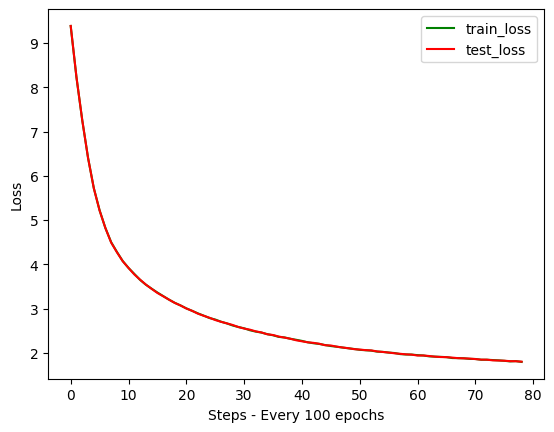

In [ ]:
import matplotlib.pyplot as plt

train_loss_list_converted = [i.cpu().detach() for i in train_loss_list]
test_loss_list_converted = [i.cpu().detach() for i in test_loss_list]

plt.plot(train_loss_list_converted, 'g', label='train_loss')
plt.plot(test_loss_list_converted, 'r', label="test_loss")
plt.xlabel("Steps - Every 100 epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
import os

file_path = "/content/best_model_params.pt"
file_size_bytes = os.path.getsize(file_path)
file_size_mb = file_size_bytes / (1024 * 1024)

print(f"The size of the file '{file_path}' is: {file_size_mb:.2f} MB")

The size of the file '/content/best_model_params.pt' is: 114.45 MB


####Loading Model Weights

In [ ]:
model = GPT(config)
device = "cuda" if torch.cuda.is_available() else "cpu"
best_model_params_path = "best_model_params.pt"
model.load_state_dict(torch.load(best_model_params_path, map_location=torch.device(device)))
model = model.to(device)

####Example

In [ ]:
sentence = "pumpkin is going to"
context = (torch.tensor(enc.encode_ordinary(sentence)).unsqueeze(dim=0))
y = model.generate(context, 200)
print(enc.decode(y.squeeze().tolist()))


pumpkin is going to rest. The snowigs are not good to melt. Tom and Sue want that snow and Sue feel good. They think they will feel better. But they can't see the snowmen. They can smell the snow soaring and fall from the air. They cannot enjoy it because the snow is rained.
"Let's leave the snowman," Tom says.
Sara says. She wipes her tears. Then she smiles. She sees the snowman smiling at Tom. He picks it up. He wants to return home. But it is a surprise. He does not mind lamps and hats or crayons.
The snowman players are not moving. He is notPop. He has an idea. He tells them that he won't burn things anymore. He says God and stains the snowman and his flags and shells.
Sara sees him and stops his skin. She smiles and hugs Tommy. She says he has his own discoveries. She calls the captain of him again
